In [3]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo


from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram
from constants import MASS_BINS
from mass_function import get_weighted_mass_histogram_cluster_galaxies

In [4]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey (this is the main one)
galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters EFEDS

print('number of galaxies: ', len(sciencegkv_galaxies_raw))
print('number of galaxies: ', len(galaxies_raw))
print('number of the clusters: ', len(clusters_raw))

number of galaxies:  2232985
number of galaxies:  370116
number of the clusters:  542


In [5]:
def get_cluster_volume_sum_from_mass(mass, cluster_dataframe, z_min=0, z_max=999):
    cut_off_distance = get_max_distance_from_richards_curve(np.log10(mass))
    reduced_cluster_dataframe = cluster_dataframe[(cluster_dataframe['distance'] <= cut_off_distance) & (cluster_dataframe['z'] >= z_min) & (cluster_dataframe['z'] <= z_max)]
    return sum(reduced_cluster_dataframe["cluster_volume"])

def get_comoving_distance_from_redshift(redshift):
    return cosmo.comoving_distance(redshift).value

def get_sphere_volume(radius):
    return 4 / 3 * np.pi * radius ** 3

def get_max_distance_from_richards_curve(log_mass):
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (log_mass - M))) ** (1 / nu)
    return y

def is_within_polygon(x, y):
    lower_bound_y = 1.3
    upper_bound_x = 1.7
    diagonal_y = (7/9) * x + 0.6778
    return (y >= lower_bound_y) & (x <= upper_bound_x) & (y >= diagonal_y)

def decide_galaxy_activity(u_minus_r_mag, r_minus_j_mag):
    if is_within_polygon(u_minus_r_mag, r_minus_j_mag):
        return 'quenched'
    else:
        return 'starforming'
    

In [6]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 14,           # Font size for text
    'axes.titlesize': 16,      # Font size for axes titles
    'axes.labelsize': 14,      # Font size for x and y labels
    'xtick.labelsize': 14,     # Font size for x tick labels
    'ytick.labelsize': 14,     # Font size for y tick labels
    'legend.fontsize': 14,     # Font size for legend text
    'figure.figsize': (20, 12), # Default figure size
})

In [7]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < 0.4) &
    # (sciencegkv_galaxies_raw['Z'] <= 0.4) &
    # (sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (sciencegkv_galaxies_raw['Z'] != 0) &
    # (sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    (sciencegkv_galaxies_raw['RAcen'] > 129.0) &
    (sciencegkv_galaxies_raw['RAcen'] < 141.0) &
    (sciencegkv_galaxies_raw['Deccen'] > -2.0) &
    (sciencegkv_galaxies_raw['Deccen'] < 3.0)  &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        # (galaxies_raw['Z'] <= 0.4) &
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < 0.4) &
        (galaxies_raw['RAcen'] > 129.0) &
        (galaxies_raw['RAcen'] < 141.0) &
        (galaxies_raw['Deccen'] > -2.0) &
        (galaxies_raw['Deccen'] < 3.0)  &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP']) &  # mask clusters which don't have VDISP values
        (clusters_raw['ZBEST'] <= 0.4) &
        (clusters_raw['RA'] > 129) &
        (clusters_raw['RA'] < 141.5) &
        (clusters_raw['DEC'] > -2.05) &
        (clusters_raw['DEC'] < 3.02)
)



big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]
print('number of the galaxies in big survey after masking:   ', len(big_galaxy_catalog))
print('number of the galaxies in small survey after masking: ', len(galaxy_catalog))
print('number of the clusters after masking:                 ', len(cluster_catalog))

number of the galaxies in big survey after masking:    47105
number of the galaxies in small survey after masking:  45520
number of the clusters after masking:                  127


In [8]:
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

/media/farnoosh/LMU/nextcloud/jupyternotebooks/erosita_DR1/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [9]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['ZBEST'].byteswap().newbyteorder(),
    'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),
    # 'Cluster_MASS'
    'VDISP_error': cluster_catalog['VDISP_ERR'].byteswap().newbyteorder()
})
cluster_df['cluster_volume'] = get_sphere_volume(cluster_df['cluster_radius_Mpc'])



# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_zt': galaxy_catalog['flux_zt'].byteswap().newbyteorder(),
        'flux_it': galaxy_catalog['flux_it'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
        'flux_gt': galaxy_catalog['flux_gt'].byteswap().newbyteorder(),
        'flux_ut': galaxy_catalog['flux_ut'].byteswap().newbyteorder(),
        'log_metallicity': galaxy_catalog['logmet'].byteswap().newbyteorder(),
        'absolute_mag_u_band': galaxy_catalog['absmag_u'].byteswap().newbyteorder(),
        'absolute_mag_r_band': galaxy_catalog['absmag_r'].byteswap().newbyteorder(),
        'absolute_mag_j_band': galaxy_catalog['absmag_j'].byteswap().newbyteorder(),
})
galaxy_df['ratio_flux_zt_flux_gt'] = galaxy_df['flux_zt'] / galaxy_df['flux_gt']

galaxy_df['u_minus_r_mag'] = galaxy_df['absolute_mag_u_band'] - galaxy_df['absolute_mag_r_band']
galaxy_df['r_minus_j_mag'] = galaxy_df['absolute_mag_r_band'] - galaxy_df['absolute_mag_j_band']
galaxy_df['activity'] = galaxy_df.apply( lambda df: decide_galaxy_activity(df.r_minus_j_mag, df.u_minus_r_mag), axis=1)

<>:75: SyntaxWarning: invalid escape sequence '\o'
<>:75: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_39073/886301031.py:75: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)')


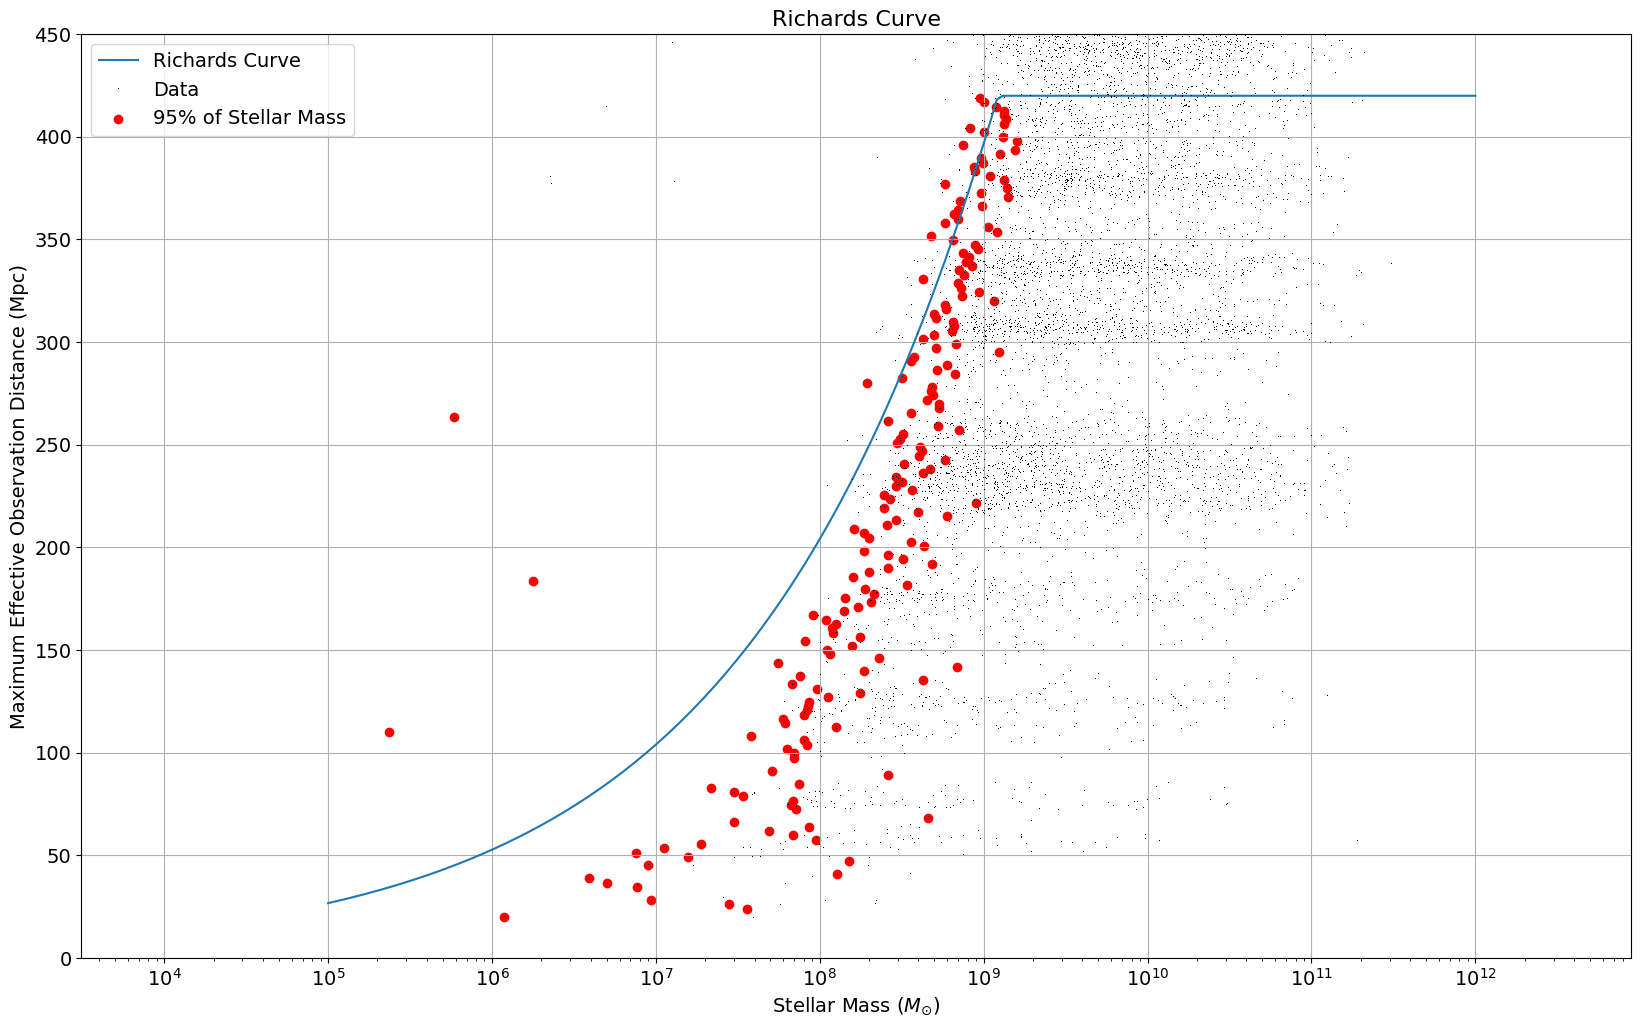

In [10]:
# from mass_function import calculate_richard_curve
# 
# MASS_BINS = np.logspace(5, 12, num=200)
# richards_curve = []
# for mass in MASS_BINS:
#     distance = calculate_richard_curve(np.log10(mass))
#     if distance < 420:
#         richards_curve.append(distance)
#     else:
#         richards_curve.append(420)
# 
# plt.plot(MASS_BINS, richards_curve)
# plt.plot((galaxy_df['mstar']), (cosmo.comoving_distance(galaxy_df['z'])), 'k,', rasterized = True)
# 
# plt.yscale('linear')
# plt.xscale('log')
# plt.title('Richards Curve')
# plt.ylabel('Maximum Effective Observation Distance (Mpc)')
# plt.xlabel('Stellar Mass ($M_{\odot}$)')
# plt.ylim(0, 450)
# plt.savefig("plots/richards_curve.png")
# 
# # should be corrected for 95% of my data

import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13 as cosmo
from mass_function import calculate_richard_curve

# Constants
MASS_BINS = np.logspace(5, 12, num=200)

# Compute the Richards curve
richards_curve = []
for mass in MASS_BINS:
    distance = calculate_richard_curve(np.log10(mass))
    if distance < 420:
        richards_curve.append(distance)
    else:
        richards_curve.append(420)

# Plot Richards curve
plt.plot(MASS_BINS, richards_curve, label='Richards Curve')

# Convert galaxy stellar mass and redshift to comoving distance
galaxy_df['comoving_distance'] = cosmo.comoving_distance(galaxy_df['z']).value

# Calculate 95th percentile of masses within each bin of comoving distance
num_bins = 200
bin_width = 420 / num_bins  # Use the range of comoving distances instead of log(mass)

bin_center = []
mass_percentile = []

for i in range(num_bins):
    bin_start = i * bin_width
    bin_end = (i + 1) * bin_width
    objects_in_bin = galaxy_df['mstar'][(galaxy_df['comoving_distance'] >= bin_start) & (galaxy_df['comoving_distance'] < bin_end)]
    if len(objects_in_bin) > 0:
        sorted_masses = np.sort(objects_in_bin)[::-1]
        idx_95th_percentile = int(0.95 * len(sorted_masses))
        mass_95th_percentile = sorted_masses[idx_95th_percentile]
        bin_center.append((bin_start + bin_end) / 2)
        mass_percentile.append(mass_95th_percentile)

# Plot scatter of galaxy data and 95th percentile of masses
plt.plot(galaxy_df['mstar'], galaxy_df['comoving_distance'], 'k,', rasterized=True, label='Data')
plt.scatter(mass_percentile, bin_center, color='red', marker='o', label='95% of Stellar Mass')

# Plot settings
plt.yscale('linear')
plt.xscale('log')
plt.title('Richards Curve')
plt.ylabel('Maximum Effective Observation Distance (Mpc)')
plt.xlabel('Stellar Mass ($M_{\odot}$)')
plt.ylim(0, 450)
plt.legend()
plt.grid(True)
plt.savefig("plots/richards_curve.png")
plt.show()


In [11]:
print(len(galaxy_df[(galaxy_df['activity'] == 'starforming') & (galaxy_df['z'] < 0.4)]))
print(len(galaxy_df[(galaxy_df['activity'] == 'quenched') & (galaxy_df['z'] < 0.4)]))


4526
40994


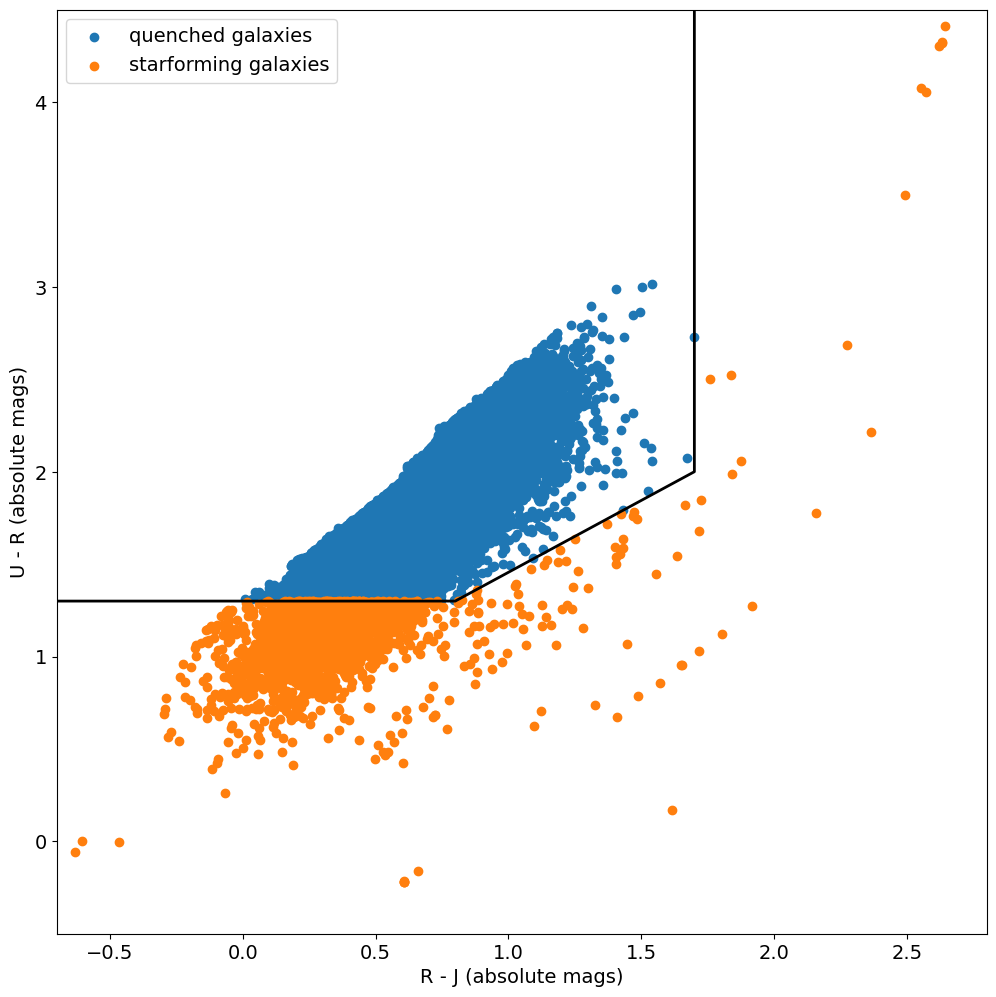

In [12]:
# source: https://www.researchgate.net/publication/51917252_The_UVJ_Selection_of_Quiescent_and_Star_Forming_Galaxies_SeparatingEarly_and_Late-Type_Galaxies_and_Isolating_Edge-on_Spirals

starforming_galaxies = galaxy_df[galaxy_df['activity'] == 'starforming']
quenched_galaxies = galaxy_df[galaxy_df['activity'] == 'quenched']

fig, ax = plt.subplots(figsize=(12, 12))

plt.scatter(quenched_galaxies['r_minus_j_mag'], quenched_galaxies['u_minus_r_mag'], marker='o', label='quenched galaxies')
plt.scatter(starforming_galaxies['r_minus_j_mag'], starforming_galaxies['u_minus_r_mag'], marker='o', label='starforming galaxies')

vertices = np.array([
    [-1, 5],       # Top left corner (extend to the left)
    [-1, 1.3],     # Bottom left corner (extend to the left)
    [0.8, 1.3],   # Start of the diagonal
    [1.7, 2.0],   # End of the diagonal
    [1.7, 5],     # Top right corner (extend to the top)
    [-1, 5]        # Close the polygon by connecting to the top left corner
])
plt.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
plt.ylim((-0.5, 4.5))
plt.xlim((-0.7, 2.8))
plt.ylabel('U - R (absolute mags)')
plt.xlabel('R - J (absolute mags)')
plt.legend()
plt.savefig("plots/quenched_starforming_classification.png", bbox_inches='tight')
plt.show()

In [13]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)

print(matched_galaxy_dataframe[matched_galaxy_dataframe['environment'] != 'Field'].head())

Progress: 99.99780316344464%%%%%              uberID          RA       DEC        z         mstar   flux_zt  \
4    130990151906125  131.440319 -0.506608  0.15497  4.314327e+10  0.000323   
103  130990156606252  131.435755 -0.494546  0.15614  5.403739e+10  0.000299   
115  133990088904009  134.499717 -0.705824  0.24617  1.333348e+11  0.000396   
120  130990157106322  131.435501 -0.488441  0.15490  2.071739e+11  0.002312   
163  140000375308747  140.229955  0.740357  0.15914  1.234358e+10  0.000099   

      flux_it   flux_rt   flux_gt   flux_ut  ...  absolute_mag_j_band  \
4    0.000239  0.000161  0.000058  0.000009  ...           -22.182413   
103  0.000229  0.000151  0.000054  0.000009  ...           -21.985081   
115  0.000301  0.000204  0.000064  0.000013  ...           -23.377264   
120  0.001776  0.001208  0.000432  0.000065  ...           -24.338562   
163  0.000078  0.000055  0.000023  0.000006  ...           -20.712473   

     ratio_flux_zt_flux_gt  u_minus_r_mag  r_minus_j_m

In [14]:
matched_galaxy_dataframe.to_csv('matched_galaxy_df.csv')

In [15]:
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [16]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner" , on="uberID")
print(merged_galaxy_df[merged_galaxy_df["environment"] != "Field"])

                uberID  completeness region  Unnamed: 0          RA       DEC  \
4      130990151906125      0.958461    G09           4  131.440319 -0.506608   
103    130990156606252      0.957437    G09         103  131.435755 -0.494546   
115    133990088904009      0.960953    G09         115  134.499717 -0.705824   
120    130990157106322      0.965963    G09         120  131.435501 -0.488441   
163    140000375308747      0.851646    G09         163  140.229955  0.740357   
...                ...           ...    ...         ...         ...       ...   
45245  130990136705562      0.962619    G09       45245  131.454678 -0.559571   
45263  132020164006107      0.926247    G09       45263  132.829446  2.491626   
45300  136991087411411      0.965435    G09       45300  136.559441 -0.008810   
45470  130990148605975      0.963208    G09       45470  131.443428 -0.520688   
45488  130990149606322      0.964371    G09       45488  131.442491 -0.487985   

             z         msta

In [17]:
# get the mass histograms (galaxy mass function) and errors

# get the histogram for all galaxies
mass_histogram_all_galaxies, mass_histogram_all_galaxies_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df, region_name="G09")

# get the histogram for all galaxies in the field
mass_histogram_field_only, mass_histogram_field_only_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "Field"], region_name="G09")
# mass_histogram_field_only, mass_histogram_field_only_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["MASS"] > or < VALUE], region_name="G09")


# get the histogram for all galaxies which are cluster members
mass_histogram_cluster_members, mass_histogram_cluster_members_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"], region_name="G09")

mass_histogram_cluster_members_low_redshift, mass_histogram_cluster_members_low_redshift_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df['z'] < 0.2], region_name="G09")
mass_histogram_cluster_members_high_redshift, mass_histogram_cluster_members_high_redshift_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df['z'] > 0.2], region_name="G09")

median_red_green_ratio = galaxy_df['ratio_flux_zt_flux_gt'].median()
mass_histogram_cluster_members_more_red, mass_histogram_cluster_members_more_red_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df['ratio_flux_zt_flux_gt'] > median_red_green_ratio], region_name="G09")
mass_histogram_cluster_members_more_green, mass_histogram_cluster_members_more_green_error = get_weighted_mass_histogram_cluster_galaxies(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df['ratio_flux_zt_flux_gt'] > median_red_green_ratio], region_name="G09")

In [18]:
cluster_df['distance'] = get_comoving_distance_from_redshift(cluster_df["z"])

cluster_volumes_by_mass_bin = [get_cluster_volume_sum_from_mass(mass=mass, cluster_dataframe=cluster_df) for mass in MASS_BINS]
cluster_volumes_by_mass_bin_low_redshift = [get_cluster_volume_sum_from_mass(mass=mass, cluster_dataframe=cluster_df, z_max=0.2) for mass in MASS_BINS]
cluster_volumes_by_mass_bin_high_redshift = [get_cluster_volume_sum_from_mass(mass=mass, cluster_dataframe=cluster_df, z_min=0.2) for mass in MASS_BINS]

print(cluster_volumes_by_mass_bin_high_redshift)
print(cluster_volumes_by_mass_bin_low_redshift)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.766932725906372, 2.9942320585250854, 4.201431751251221, 5.216331601142883, 7.414514183998108, 10.052040457725525, 11.569857835769653, 12.32517808675766, 12.32517808675766, 13.83286851644516, 16.11896938085556, 21.704696595668793, 26.959538877010345, 29.954143524169922, 38.72716122865677, 53.55533391237259, 61.616864025592804, 66.82394295930862, 70.41874551773071, 75.41631579399109, 77.2479020357132, 84.72162520885468, 103.79078805446625, 105.17569577693939, 110.58172905445099, 124.62666130065918, 130.24792647361755, 137.54133319854736, 140.1109

<>:49: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_39073/218213850.py:49: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_39073/218213850.py:50: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
/tmp/ipykernel_39073/218213850.py:49: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_39073/218213850.py:50: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)


ValueError: 'x' and 'y' must have the same size

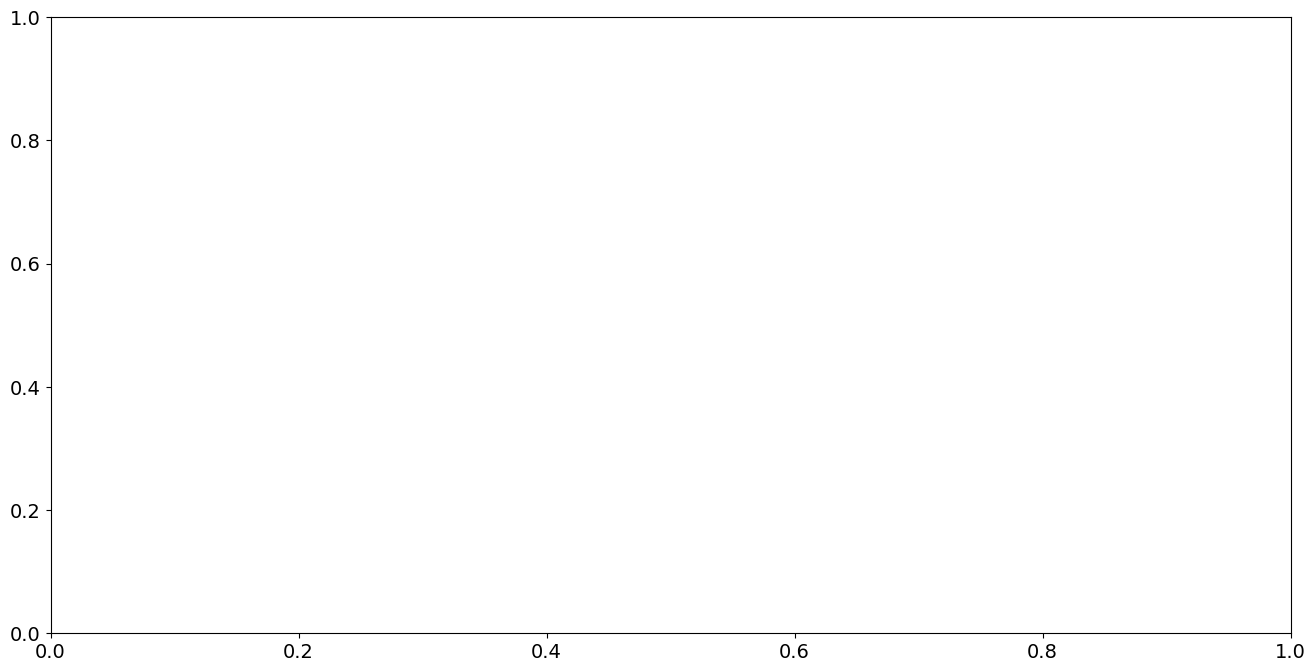

In [19]:
# Load the data from the CSV file
giodini_field4_02_to_04 = '/home/farnoosh/Desktop/thesis/giodini_fig4_field_passive_02_04.csv'
driver_fig12_z_less_than_01 = '/home/farnoosh/Desktop/thesis/driver_fig12_z_less_than0.1.csv'

giodini_field_02_to_04 = pd.read_csv(giodini_field4_02_to_04, header=None, names=['x', 'y'])
driver_fig12_01 = pd.read_csv(driver_fig12_z_less_than_01, header=None, names=['x', 'y'])

# Sort the driver data by the x-values
driver_fig12_01 = driver_fig12_01.sort_values(by='x')

fig, ax = plt.subplots(figsize=(16, 8))

ratio_of_field_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "Field"]) / len(merged_galaxy_df)
ratio_of_cluster_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"]) / len(merged_galaxy_df)

# some parameters for plotting
plt.rcParams.update({
    'font.size': 14,           # Font size for text
    'axes.titlesize': 16,      # Font size for axes titles
    'axes.labelsize': 14,      # Font size for x and y labels
    'xtick.labelsize': 14,     # Font size for x tick labels
    'ytick.labelsize': 14,     # Font size for y tick labels
    'legend.fontsize': 14,     # Font size for legend text
    'figure.figsize': (20, 12), # Default figure size
})

plt.errorbar(
    MASS_BINS[:-1],
    70*mass_histogram_all_galaxies,
    yerr=70*mass_histogram_all_galaxies_errors,
    label='All galaxies Z < 0.4',
)

# plt.errorbar(
#     MASS_BINS[:-1],
#     mass_histogram_field_only / ratio_of_field_galaxies,
#     yerr=mass_histogram_field_only_errors / ratio_of_field_galaxies,
#     label='Field only Z < 1.3',
# )



# Add the new data from the CSV file
# plt.plot(10**giodini_field_02_to_04['x'], giodini_field_02_to_04['y'] / (0.7**3), marker='o', color='red', linestyle='-', label='Giodini_Field 0.2< Z <0.4')
# plt.plot(driver_fig12_01['x'], 70*driver_fig12_01['y'], marker='o', color='gray', linestyle='-', label='Driver et al Z < 0.1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
# plt.xlim((10**9.5, 10**12))
plt.ylim((10**-3.5, 10**2))
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.savefig("GSMF_full_data_and_driver.png")

In [ ]:
print(MASS_BINS)

In [ ]:
giodini_fig_9_field_08_1 = '/home/farnoosh/Desktop/thesis/giodini_gif9_low_mass_08_1.csv'
giodini_field_08_1 = pd.read_csv(giodini_fig_9_field_08_1, header=None, names=['x', 'y'])

giodini_fig4_HGroup_08_1 = '/home/farnoosh/Desktop/thesis/giodini_fig4_High_mass_Group_08_1.csv'
giodini_HGroup_08_1 = pd.read_csv(giodini_fig4_HGroup_08_1, header=None, names=['x', 'y'])


fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[14:-1],
    mass_histogram_cluster_members[14:] / cluster_volumes_by_mass_bin[14:-1],
    yerr=mass_histogram_cluster_members_error[14:] / cluster_volumes_by_mass_bin[14:-1],
    label='eFEDs cluster members',
    color='indigo',
)

plt.plot(10**giodini_HGroup_08_1['x'], giodini_HGroup_08_1['y'], marker='o', color='lightsteelblue', linestyle='-', label='giodini_Group 0.8 < Z < 1')

vertical_line_position = 10**10.7
plt.axvline(x=vertical_line_position, color='black', linestyle='--')
plt.axvspan(10**10, vertical_line_position, color='gray', alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
# plt.xlim((10**10, 10**12))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[14:-1],
    mass_histogram_cluster_members_low_redshift[14:] / cluster_volumes_by_mass_bin_low_redshift[14:-1],
    yerr=mass_histogram_cluster_members_low_redshift_error[14:] / cluster_volumes_by_mass_bin_low_redshift[14:-1],
    label='z < 0.2',
)
plt.errorbar(
    MASS_BINS[14:-1],
    mass_histogram_cluster_members_high_redshift[14:] / cluster_volumes_by_mass_bin_high_redshift[14:-1],
    yerr=mass_histogram_cluster_members_high_redshift_error[14:] / cluster_volumes_by_mass_bin_high_redshift[14:-1],
    label='z > 0.2',
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)
plt.xlim((10**8, 10**12))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_106304/2742240807.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_106304/2742240807.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1}$)', fontsize=16)


ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1600x800 with 1 Axes>

In [89]:

# Find the clusters that have galaxies among them
unique_cluster_ids = matched_galaxy_dataframe['cluster_name'].unique()

# Print the clusters and their galaxies
cluster_galaxies = matched_galaxy_dataframe.groupby('cluster_name')['uberID'].apply(list).reset_index()
cluster_galaxies['num_galaxies'] = cluster_galaxies['uberID'].apply(len)

# Print the clusters with galaxies
for index, row in cluster_galaxies.iterrows():
    print(f"Cluster {row['cluster_name']} has the following {len(row['uberID'])} galaxies within: {row['uberID']}")

Cluster eFEDSJ083651.3+030002 has the following 2 galaxies within: [129020867111101, 129020874611193]
Cluster eFEDSJ083654.6+025954 has the following 19 galaxies within: [129020754611149, 129020765311309, 129020772711257, 129020773010920, 129020778211401, 129020789011021, 129020798811315, 129020805311478, 129020809511497, 129020813311435, 129020814211457, 129020818011458, 129020818111167, 129020818710946, 129020830411303, 129020830411211, 129020837511203, 129020843911386, 129020864311407]
Cluster eFEDSJ083723.6+012413 has the following 2 galaxies within: [129010249405188, 129010251405245]
Cluster eFEDSJ083802.9+015626 has the following 1 galaxies within: [129020496200495]
Cluster eFEDSJ083807.6+002501 has the following 6 galaxies within: [129000030605704, 129000034306108, 129000062305810, 130001047205365, 130001073105548, 130001116905236]
Cluster eFEDSJ083834.1+020643 has the following 1 galaxies within: [129020360402063]
Cluster eFEDSJ083857.5+020846 has the following 1 galaxies withi

In [90]:
# Find the maximum number of galaxies in a cluster
max_galaxies_row = cluster_galaxies.loc[cluster_galaxies['num_galaxies'].idxmax()]
print(f"Cluster {max_galaxies_row['cluster_name']} has the maximum number of galaxies: {max_galaxies_row['num_galaxies']}")

# Count the number of clusters with only one galaxy within them
clusters_with_one_galaxy = sum(cluster_galaxies['num_galaxies'] == 1)
print(f"Number of clusters with only one galaxy: {clusters_with_one_galaxy}")

Cluster eFEDSJ085027.8+001503 has the maximum number of galaxies: 54
Number of clusters with only one galaxy: 15


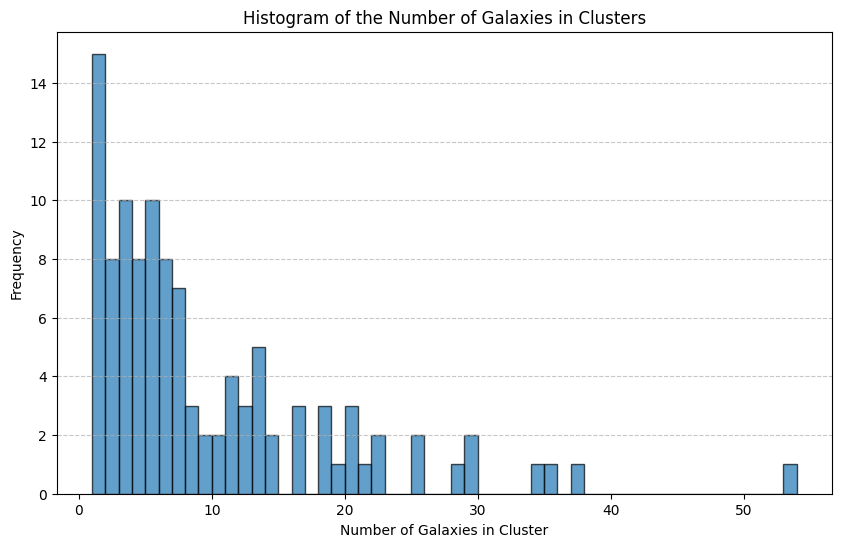

In [91]:
plt.figure(figsize=(10, 6))
plt.hist(cluster_galaxies['num_galaxies'], bins=range(1, cluster_galaxies['num_galaxies'].max() + 1), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Galaxies in Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Galaxies in Clusters')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [92]:
# Calculate the total number of galaxies within clusters
total_galaxies = cluster_galaxies['num_galaxies'].sum()
print(f"Total number of galaxies within clusters: {total_galaxies}")

Total number of galaxies within clusters: 1017


In [93]:
# Find clusters with no galaxies
all_cluster_names = cluster_df['c_NAME'].unique()
clusters_with_galaxies = matched_galaxy_dataframe['cluster_name'].dropna().unique()
clusters_without_galaxies = np.setdiff1d(all_cluster_names, clusters_with_galaxies)

print('number of clusters with galaxies among them:', len(clusters_with_galaxies))
print("number of clusters with no galaxies within: ", len(clusters_without_galaxies))
# for cluster_name in clusters_without_galaxies:
#     print(f"Cluster name without a galaxy: {cluster_name}")

number of clusters with galaxies among them: 109
number of clusters with no galaxies within:  53


In [16]:
# FIELD
#  star forming
#   z > 0.2
mass_histogram_field_starforming_high_z, mass_histogram_field_starforming_high_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] != "ClusterMember") &
        (merged_galaxy_df["activity"] == 'starforming') &
        (merged_galaxy_df["z"] > 0.2)
    ],
    region_name="G09"
)
#   z < 0.4
mass_histogram_field_starforming_low_z, mass_histogram_field_starforming_low_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] != "ClusterMember") &
        (merged_galaxy_df["activity"] == 'starforming') &
        (merged_galaxy_df["z"] < 0.4)
    ],
    region_name="G09"
)
#  quenched
#   z > 0.2
mass_histogram_field_quenched_high_z, mass_histogram_field_quenched_high_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] != "ClusterMember") &
        (merged_galaxy_df["activity"] == 'quenched') &
        (merged_galaxy_df["z"] > 0.2)
    ],
    region_name="G09"
)
#   z < 0.4
mass_histogram_field_quenched_low_z, mass_histogram_field_quenched_low_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] != "ClusterMember") &
        (merged_galaxy_df["activity"] == 'quenched') &
        (merged_galaxy_df["z"] < 0.4)
    ],
    region_name="G09"
)

# CLUSTER
#  star forming
#   z > 0.2
mass_histogram_cluster_starforming_high_z, mass_histogram_cluster_starforming_high_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] == "ClusterMember") &
        (merged_galaxy_df["activity"] == 'starforming') &
        (merged_galaxy_df["z"] > 0.2)
    ],
    region_name="G09"
)
#   z < 0.4
mass_histogram_cluster_starforming_low_z, mass_histogram_cluster_starforming_low_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] == "ClusterMember") &
        (merged_galaxy_df["activity"] == 'starforming') &
        (merged_galaxy_df["z"] < 0.4)
    ],
    region_name="G09"
)
#  quenched
#   z > 0.2
mass_histogram_cluster_quenched_high_z, mass_histogram_cluster_quenched_high_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] == "ClusterMember") &
        (merged_galaxy_df["activity"] == 'quenched') &
        (merged_galaxy_df["z"] > 0.2)
    ],
    region_name="G09"
)
#   z < 0.4
mass_histogram_cluster_quenched_low_z, mass_histogram_cluster_quenched_low_z_error = get_weighted_mass_histogram_cluster_galaxies(
    input_mass_completeness_dataframe=merged_galaxy_df[
        (merged_galaxy_df["environment"] == "ClusterMember") &
        (merged_galaxy_df["activity"] == 'quenched') &
        (merged_galaxy_df["z"] < 0.4)
    ],
    region_name="G09"
)


In [32]:
print(cluster_volumes_by_mass_bin_high_redshift[6:12])
print(mass_histogram_cluster_starforming_high_z[6:12])
print(MASS_BINS[6:12])

[0, 0, 0, 0, 0, 12.32517808675766]
[ 0.          0.          0.         10.27820214  4.90871964 10.46436532]
[1.00000000e+08 3.16227766e+08 1.00000000e+09 3.16227766e+09
 1.00000000e+10 3.16227766e+10]


<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_106304/184600078.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_106304/184600078.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
/tmp/ipykernel_106304/184600078.py:9: RuntimeWarning: divide by zero encountered in divide
  mass_histogram_field_starforming_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
/tmp/ipykernel_106304/184600078.py:10: RuntimeWarning: divide by zero encountered in divide
  yerr=mass_histogram_field_starforming_high_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower

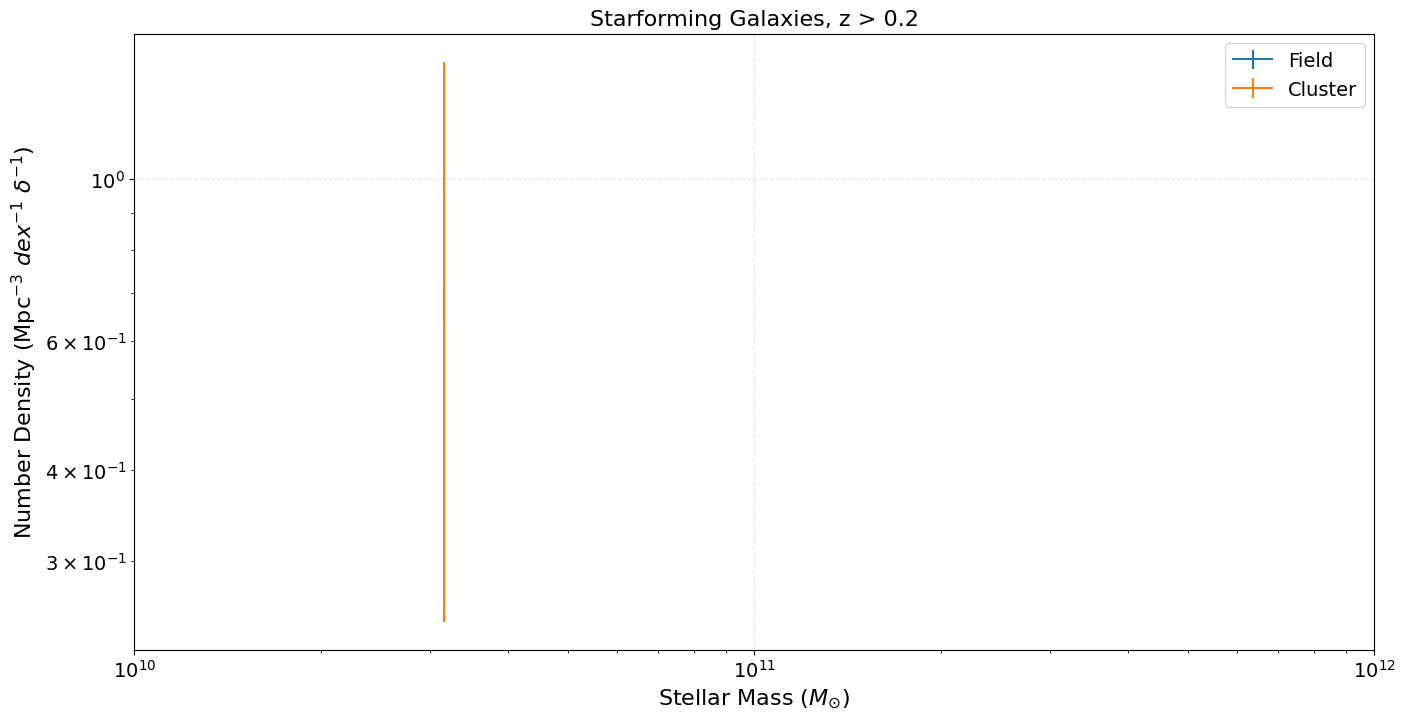

In [78]:
# PLOTTING STAR FORMING & HIGH Z
lower_mass_bound = 6
upper_mass_bound = 12

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_field_starforming_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
    yerr=mass_histogram_field_starforming_high_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
    label='Field',
)
plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_cluster_starforming_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound],
    yerr=mass_histogram_cluster_starforming_high_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound],
    label='Cluster',
)
plt.title('Starforming Galaxies, z > 0.2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
plt.xlim((10**10, 10**12))
plt.legend()
plt.savefig('plots/mass_histogram_starforming_02_to_04.png')
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_106304/3361154147.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_106304/3361154147.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
/tmp/ipykernel_106304/3361154147.py:9: RuntimeWarning: divide by zero encountered in divide
  mass_histogram_field_starforming_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
/tmp/ipykernel_106304/3361154147.py:10: RuntimeWarning: divide by zero encountered in divide
  yerr=mass_histogram_field_starforming_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower

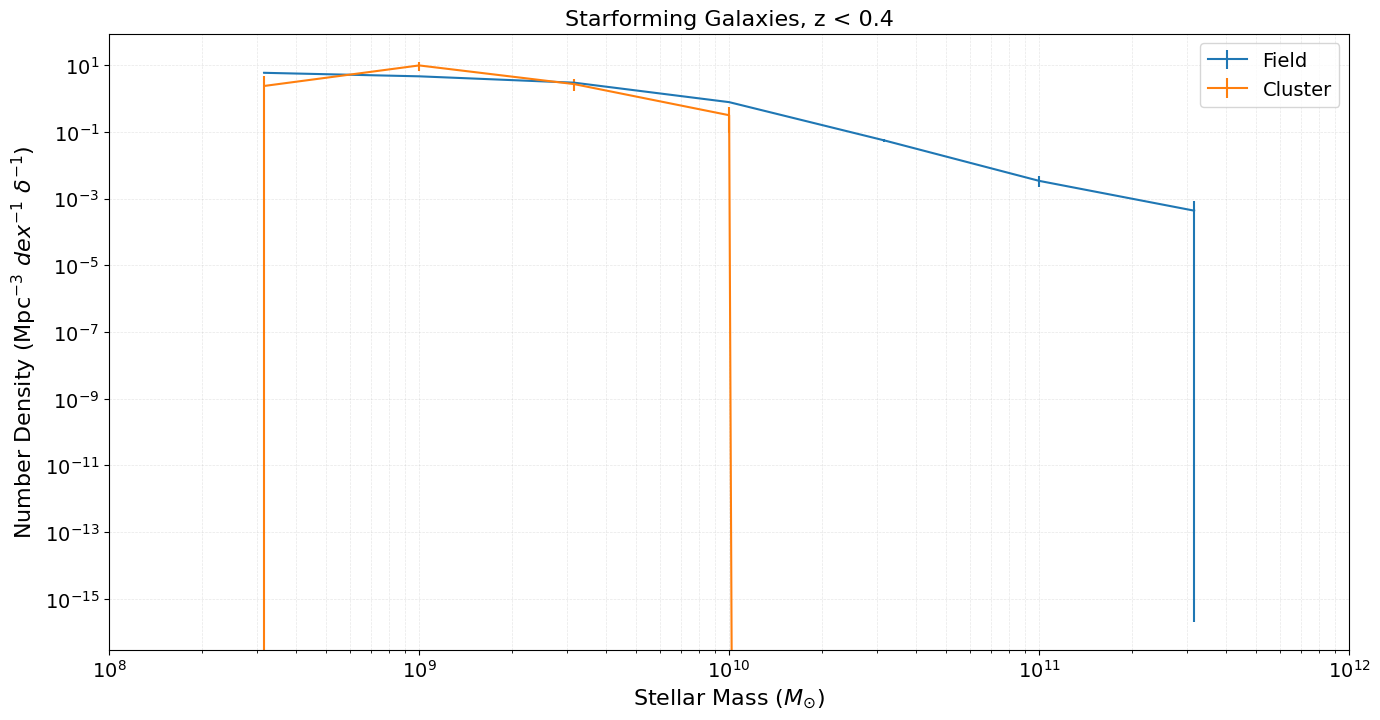

In [85]:
# PLOTTING STAR FORMING & LOW Z 
lower_mass_bound = 4
upper_mass_bound = 14

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_field_starforming_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
    yerr=mass_histogram_field_starforming_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
    
    label='Field',
)
plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_cluster_starforming_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound],
    yerr=mass_histogram_cluster_starforming_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound],
    label='Cluster',
)
plt.title('Starforming Galaxies, z < 0.4')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
plt.xlim((10**8, 10**12))
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/mass_histogram_starforming_00_to_04_largebin.png')
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_106304/761044360.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_106304/761044360.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
/tmp/ipykernel_106304/761044360.py:9: RuntimeWarning: divide by zero encountered in divide
  mass_histogram_field_quenched_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
/tmp/ipykernel_106304/761044360.py:9: RuntimeWarning: invalid value encountered in divide
  mass_histogram_field_quenched_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_m

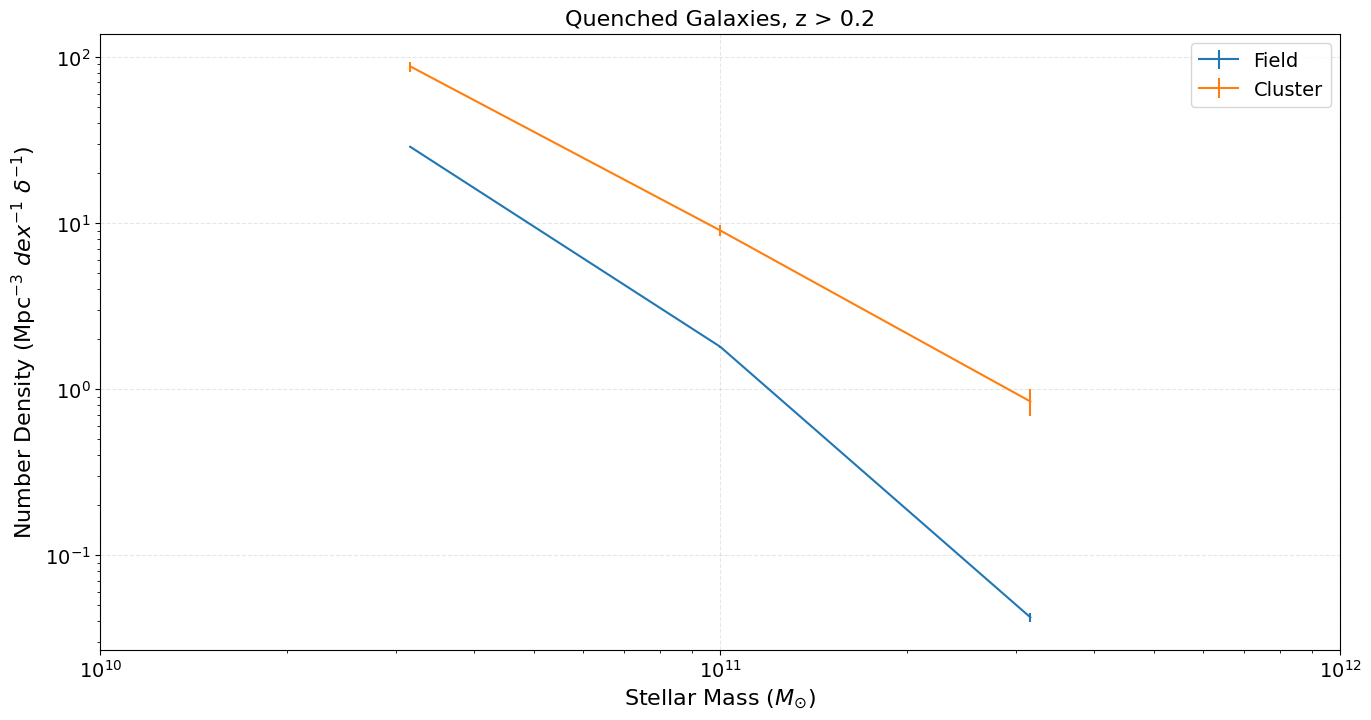

In [80]:
# PLOTTING QUENCHED & HIGH Z
lower_mass_bound = 4
upper_mass_bound = 14

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_field_quenched_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
    yerr=mass_histogram_field_quenched_high_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound] / 200,
    label='Field',
)
plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_cluster_quenched_high_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound],
    yerr=mass_histogram_cluster_quenched_high_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_high_redshift[lower_mass_bound:upper_mass_bound],
    label='Cluster',
)
plt.title('Quenched Galaxies, z > 0.2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
plt.xlim((10**10, 10**12))
plt.legend()
plt.savefig('plots/mass_histogram_quenched_02_to_04.png')
plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_106304/1731761578.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
/tmp/ipykernel_106304/1731761578.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
/tmp/ipykernel_106304/1731761578.py:9: RuntimeWarning: divide by zero encountered in divide
  mass_histogram_field_quenched_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
/tmp/ipykernel_106304/1731761578.py:10: RuntimeWarning: divide by zero encountered in divide
  yerr=mass_histogram_field_quenched_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_

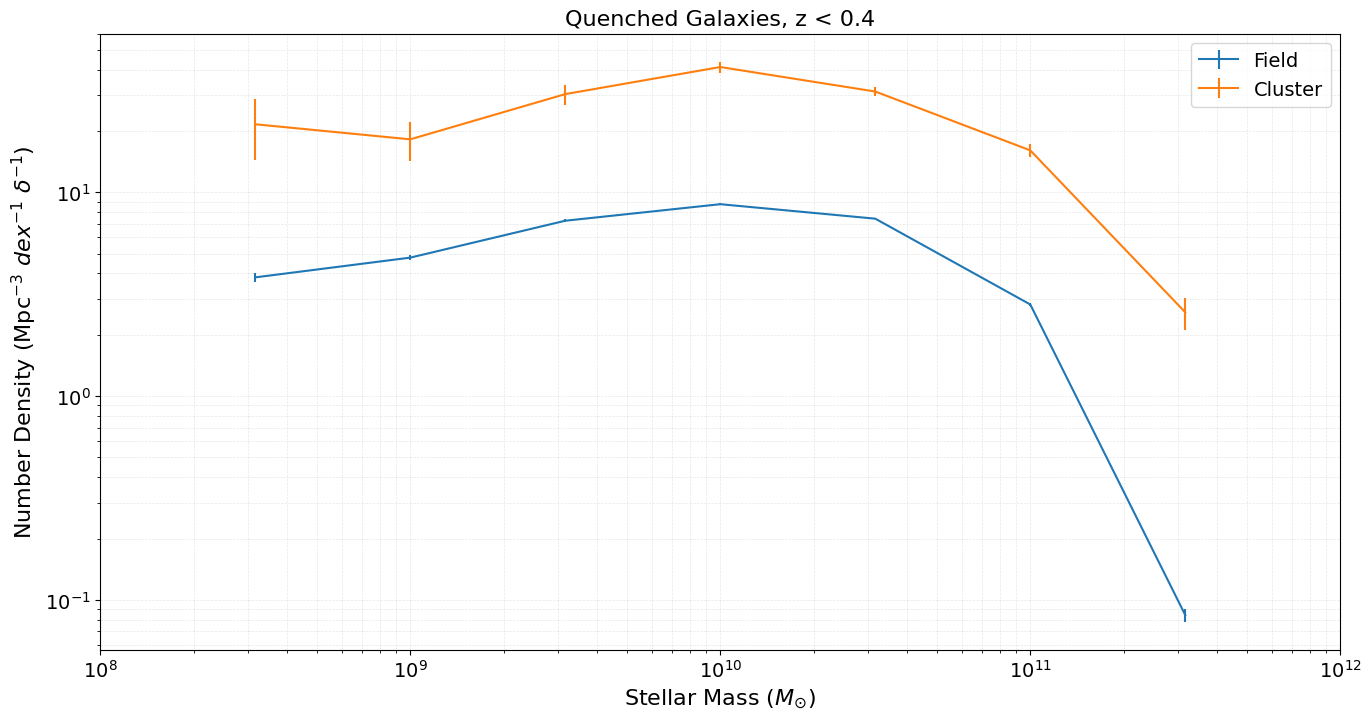

In [81]:
# PLOTTING QUENCHED & LOW Z
lower_mass_bound = 4
upper_mass_bound = 14

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_field_quenched_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
    yerr=mass_histogram_field_quenched_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound] / 200,
    label='Field',
)
plt.errorbar(
    MASS_BINS[lower_mass_bound:upper_mass_bound],
    mass_histogram_cluster_quenched_low_z[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound],
    yerr=mass_histogram_cluster_quenched_low_z_error[lower_mass_bound:upper_mass_bound] / cluster_volumes_by_mass_bin_low_redshift[lower_mass_bound:upper_mass_bound],
    label='Cluster',
)
plt.title('Quenched Galaxies, z < 0.4')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ \delta^{-1}$)', fontsize=16)
plt.xlim((10**8, 10**12))
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/mass_histogram_quenched_00_to_04_largebin.png')
plt.show()